In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import zipfile

from tqdm import tqdm   # Progress bar
from IPython.display import Audio, display

import cv2

import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.cuda.manual_seed(6)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
def allDone():
    display(Audio(url='../../chicken.mp3', autoplay=True))

In [3]:
train_val_labels = pd.read_csv('../input/train.csv')
train_val_labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


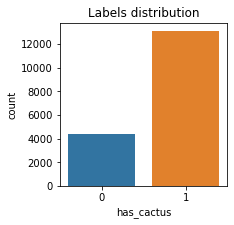

In [4]:
plt.figure(figsize=(3,3))
plt.title('Labels distribution')
sns.countplot(train_val_labels['has_cactus']);

In [5]:
# Вывод сэмплов на экран

def show_sample_images(dataloader, batch_size, images_from_batch=0):

    if images_from_batch == 0 or images_from_batch > batch_size:
            images_from_batch = batch_size
        
    for images, labels in dataloader:
        plt.figure(figsize=(20, (batch_size // 20 + 1) * 3))

        cols = 12
        rows = batch_size // cols + 1
        for i in range(images_from_batch):
            plt.subplot(rows, cols, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i].permute(1, 2, 0)) # Размерность RGB в конец
            plt.xlabel(classes[labels[i].numpy()])
        plt.show()
        
        break

## Batch size!

In [6]:
batch_size = 100
# 500 неплохо, попробовать ещё (sched - 25 step)
# 250 - 99,48%
# 50 - 99,08%

train_dir = r'C:\Temp\train'
val_dir = r'C:\Temp\val'

classes = ['No', 'Cactus']

train_transforms = transforms.Compose([
    transforms.Resize(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)


# Протестировали загрузку, узнали размер тензора
for images, labels in train_dataloader:
    print(images.size())
    print(labels.size())
    break

torch.Size([100, 3, 224, 224])
torch.Size([100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

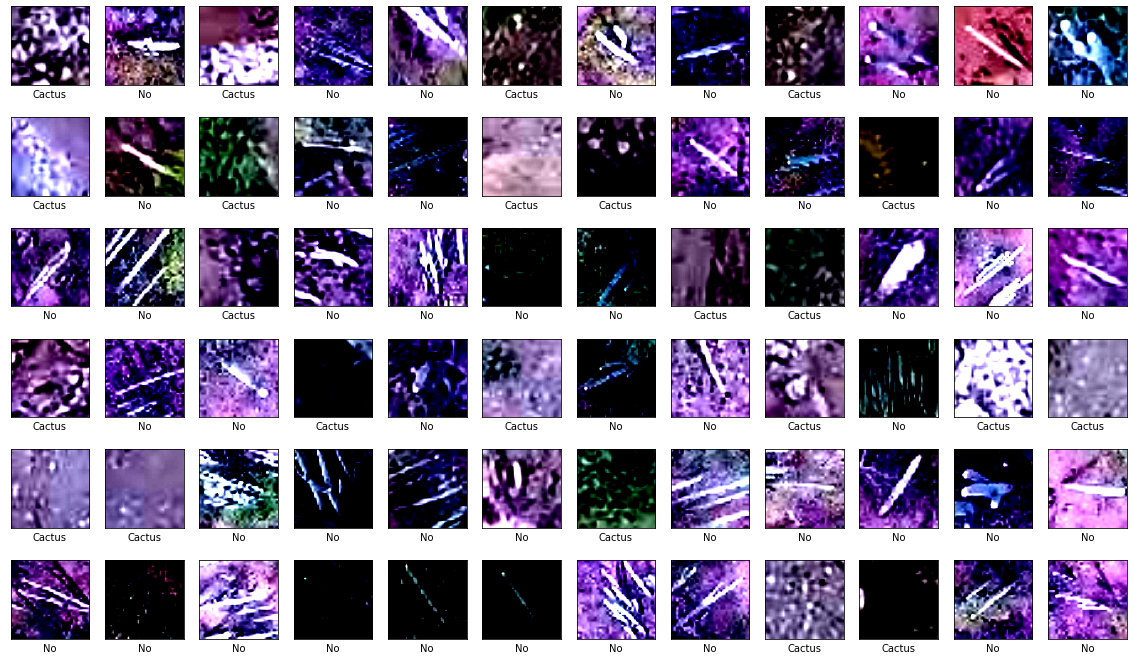

In [7]:
# Теперь посмотрим на картиночки

show_sample_images(train_dataloader, batch_size, 72)

In [8]:
print(f'Batch size: {batch_size}')
print(f'Train batches: {len(train_dataloader)}, Train samples: {len(train_dataset)}')
print(f'Val batches:   {len(val_dataloader)}, Val samples:    {len(val_dataset)}')

Batch size: 100
Train batches: 150, Train samples: 15000
Val batches:   25, Val samples:    2500


In [9]:
train_batch_loss_history = []
train_batch_accuracy_history = []

train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

def validate(model, loss, optimizer):
        
    dataloader = val_dataloader
    model.eval()   # Set model to evaluate mode

    sum_loss = 0.
    sum_accuracy = 0.

    for inputs, labels in dataloader: # tqdm(dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

        sum_loss += loss_value.item()
        sum_accuracy += (preds_class == labels.data).float().mean().cpu().numpy().item()

    val_loss = sum_loss / len(dataloader)
    val_accuracy = sum_accuracy / len(dataloader)

    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    
    print(f'Validation accuracy {val_accuracy * 100:.2f} %, loss {val_loss:.4f}')
#     if val_accuracy >= 0.99:
#         allDone()
#         input()

    model.train()  # Вернули как было


def train_model(model, loss, optimizer, scheduler, num_epochs):
        
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs-1}: \n', end='')

        dataloader = train_dataloader
        model.train()  # Set model to training mode

        sum_loss = 0.
        sum_accuracy = 0.

        # Прогон по батчам
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                loss_value.backward()
                optimizer.step()
                # scheduler.step()

            batch_loss = loss_value.item()
            batch_accuracy = (preds_class == labels.data).float().mean().cpu().numpy().item()

            sum_loss += batch_loss
            sum_accuracy += batch_accuracy
            
            train_batch_loss_history.append(batch_loss)
            train_batch_accuracy_history.append(batch_accuracy)
            #print(f'\r----- {phase}, batch accuracy {train_batch_accuracy * 100:.2f} %, batch loss {train_batch_loss:.4f}')        
            #validate(model, loss, optimizer)
            
        epoch_loss = sum_loss / len(dataloader)
        epoch_acc = sum_accuracy / len(dataloader)

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_acc)
        scheduler.step()

        # Валидация
        print('\n End epoch: ', end='')
        validate(model, loss, optimizer)
        
    return model

In [10]:
model = models.resnet18(pretrained=False)

#model = CactusNet()
#model = models.mobilenet_v2(pretrained=True)

# Disable grad for all conv layers - замораживаем слои ResNet
# for param in model.parameters():
#     param.requires_grad = False

# Заменяем последний слой на наш (512 входов, 2 выхода) (пересоздаём, поэтому будет разморожен)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
#model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

model = model.cuda()

loss = torch.nn.CrossEntropyLoss() #weight=torch.FloatTensor([1, 1]).cuda())
optimizer = torch.optim.Adam(model.parameters())#, lr=1.0e-3, weight_decay=0.01, amsgrad=True)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)  

In [11]:
print(f'Batch size: {batch_size}\nBatches: {len(train_dataloader)}\nAll elements: {len(train_dataset)}')

Batch size: 100
Batches: 150
All elements: 15000


In [12]:
# Тренировочка
epochs = int(np.sqrt(batch_size)) + 20  # Чтобы автоматически выбиралось

train_model(model, loss, optimizer, scheduler, num_epochs=epochs)
allDone()


Epoch 0/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:55<00:00,  1.29it/s]



 End epoch: Validation accuracy 96.36 %, loss 0.0983

Epoch 1/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.32it/s]



 End epoch: Validation accuracy 94.56 %, loss 0.1575

Epoch 2/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:55<00:00,  1.30it/s]



 End epoch: Validation accuracy 98.16 %, loss 0.0464

Epoch 3/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 98.40 %, loss 0.0439

Epoch 4/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:57<00:00,  1.28it/s]



 End epoch: Validation accuracy 98.68 %, loss 0.0377

Epoch 5/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.16 %, loss 0.0202

Epoch 6/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.36 %, loss 0.0188

Epoch 7/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:57<00:00,  1.28it/s]



 End epoch: Validation accuracy 97.92 %, loss 0.0564

Epoch 8/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:02<00:00,  1.23it/s]



 End epoch: Validation accuracy 99.00 %, loss 0.0327

Epoch 9/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:59<00:00,  1.25it/s]



 End epoch: Validation accuracy 99.44 %, loss 0.0162

Epoch 10/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:58<00:00,  1.27it/s]



 End epoch: Validation accuracy 98.96 %, loss 0.0277

Epoch 11/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:58<00:00,  1.27it/s]



 End epoch: Validation accuracy 99.52 %, loss 0.0154

Epoch 12/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:56<00:00,  1.29it/s]



 End epoch: Validation accuracy 99.20 %, loss 0.0229

Epoch 13/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.40 %, loss 0.0167

Epoch 14/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.48 %, loss 0.0185

Epoch 15/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:56<00:00,  1.28it/s]



 End epoch: Validation accuracy 99.56 %, loss 0.0130

Epoch 16/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.24 %, loss 0.0181

Epoch 17/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.60 %, loss 0.0104

Epoch 18/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.40 %, loss 0.0212

Epoch 19/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.56 %, loss 0.0161

Epoch 20/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.80 %, loss 0.0063

Epoch 21/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.76 %, loss 0.0069

Epoch 22/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.76 %, loss 0.0071

Epoch 23/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.76 %, loss 0.0068

Epoch 24/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.80 %, loss 0.0067

Epoch 25/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.72 %, loss 0.0076

Epoch 26/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.84 %, loss 0.0062

Epoch 27/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.72 %, loss 0.0072

Epoch 28/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.76 %, loss 0.0069

Epoch 29/29: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]



 End epoch: Validation accuracy 99.76 %, loss 0.0076


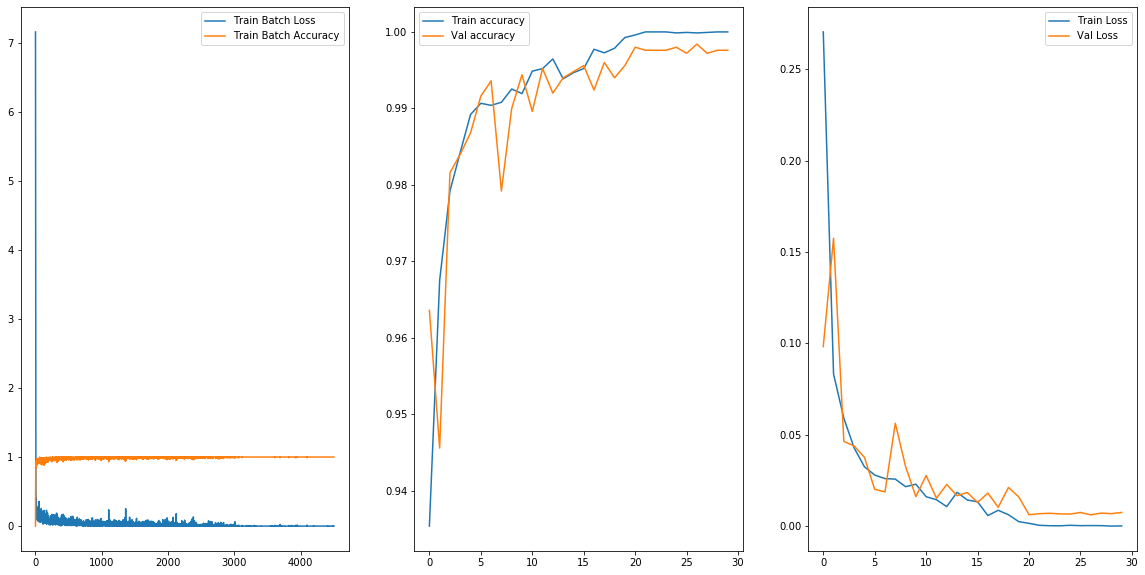

In [13]:
plt.figure(figsize=(20,10))
    
plt.subplot(1, 3, 1)
plt.plot(train_batch_loss_history, label='Train Batch Loss')
plt.plot(train_batch_accuracy_history, label='Train Batch Accuracy')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(val_accuracy_history, label='Val accuracy')
plt.legend();
    
plt.subplot(1, 3, 3)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend();